# COLOR MAPPING

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
import matplotlib as mpl
import numpy.ma as ma
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from scipy.ndimage import maximum_filter, minimum_filter

In [142]:
#This function calculates the global minimum and maximum of a variable as explained in the report. Calculates min max for each sampled day and then returns the global min and max.
def calculate_global_min_max(filename, var_name):

    data = Dataset(filename, 'r')
    variable_data= data.variables[var_name][:]
    day_indices = [236, 238, 239, 240, 241, 242,243] # the days that we have sampled , 2005-08-25, 2005-08-27, 2005-08-28, 2005-08-29, 2005-08-30, 2005-08-31, 2005-09-1  .
    
    global_min =np.inf
    global_max =-np.inf
    
    for index in day_indices:
        day_data = variable_data[index, :, :]
        
        day_min=np.min(day_data[day_data > 0]) if np.any(day_data > 0) else global_min
        day_max=np.max(day_data)
        
        global_min=min(global_min, day_min)
        global_max=max(global_max, day_max)
   
    data.close()
    return global_min, global_max

In [143]:
#This function loads the data from the file
def get_data(filename, var_name, day_index):

    data=Dataset(filename, 'r')
    lats=data.variables['lat'][:]
    lons=data.variables['lon'][:]
    variable_data = data.variables[var_name][:]

    vmin, vmax =calculate_global_min_max(filename, var_name)
    day_data =variable_data[day_index, :, :]
    
    data.close()
    return lons, lats, day_data, vmin, vmax


In [144]:
#We have loaded the dates in the form of its index in the file.This function returns the date of the day index.
def get_date(day_index):

    day_index_to_date = {
    236: "25-08-2005",
    238: "27-08-2005",       
    239: "28-08-2005",
    240: "29-08-2005",
    241: "30-08-2005",
    242: "31-08-2005",
    243: "01-09-2005",
}

    return day_index_to_date.get(day_index)

### Continuous,Discrete and Logarithmic Colormapping for Precipitation_Amount variable

In [145]:
#This function creates plot using continuous scale
def plot_variable_continuous(filename, var_name, day_index, units):

    lons, lats, day_data, vmin, vmax = get_data(filename, var_name, day_index)

    lon, lat =np.meshgrid(lons, lats)

    fig, ax =plt.subplots(figsize=(16, 8))
    cmap=plt.get_cmap('viridis')

    pcm = ax.pcolormesh(lon, lat, day_data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)

    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
    cbar.set_label(f'{var_name} Amount {units}')

    date = get_date(day_index)
    ax.set_title(f'{var_name} on {date}')

    ax.set_xticks([-120, -110, -100, -90, -80, -70])
    ax.set_xticklabels([f'{abs(x)}°W' for x in [-120, -110, -100, -90, -80, -70]])
    ax.set_yticks([30, 35, 40, 45])
    ax.set_yticklabels([f'{y}°N' for y in [30, 35, 40, 45]])

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    plt.show()

In [146]:
#This function creates plot using discrete scale
def plot_variable_discrete(filename, var_name, day_index,units):
    lons, lats, day_data, vmin, vmax = get_data(filename, var_name, day_index)
    lon, lat = np.meshgrid(lons, lats)
    
    fig, ax = plt.subplots(figsize=(16, 8))

   
    colors = plt.get_cmap('viridis', 9).colors.tolist()  
    colors.append((1.0, 0.0, 0.0))  
    d_cmap = mcolors.ListedColormap(colors)  
    
    pcm = ax.pcolormesh(lon, lat, day_data, shading='auto', cmap=d_cmap, vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
    cbar.set_label(f'{var_name} Amount {units}')

    date=get_date(day_index)
    ax.set_xticks([-120, -110, -100, -90, -80, -70])
    ax.set_xticklabels([f'{abs(x)}°W' for x in [-120, -110, -100, -90, -80, -70]])
    ax.set_yticks([30, 35, 40, 45])
    ax.set_yticklabels([f'{y}°N' for y in [30, 35, 40, 45]])

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name} on {date}')

    plt.show()
  

In [147]:
#This function creates plot using logarithmic scale 
def plot_variable_log(filename, var_name, day_index):

    lons, lats, day_data, vmin, vmax = get_data(filename, var_name, day_index)
    lon, lat = np.meshgrid(lons, lats)
    
    min_positive_value = np.min(day_data[day_data > 0])


    day_data_adjusted = np.where(day_data > 0, day_data, min_positive_value)


    day_data_masked = ma.masked_where(day_data < 0, day_data_adjusted)


    fig, ax = plt.subplots(figsize=(16, 8))
    cmap = plt.get_cmap('viridis')  
    cmap.set_bad(color='white') 

    
    pcm = ax.pcolormesh(lon, lat, day_data_masked, shading='auto', cmap=cmap,
                        norm=LogNorm(vmin=min_positive_value, vmax=day_data_masked.max()))

    
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
    cbar.set_label(f'{var_name} Amount (log scale)')

    date=get_date(day_index)
    ax.set_xticks([-120, -110, -100, -90, -80, -70])
    ax.set_xticklabels([f'{abs(x)}°W' for x in [-120, -110, -100, -90, -80, -70]])
    ax.set_yticks([30, 35, 40, 45])
    ax.set_yticklabels([f'{y}°N' for y in [30, 35, 40, 45]])

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'{var_name} on {date}')

    plt.show()
    plt.savefig('logarithmic.png')
    



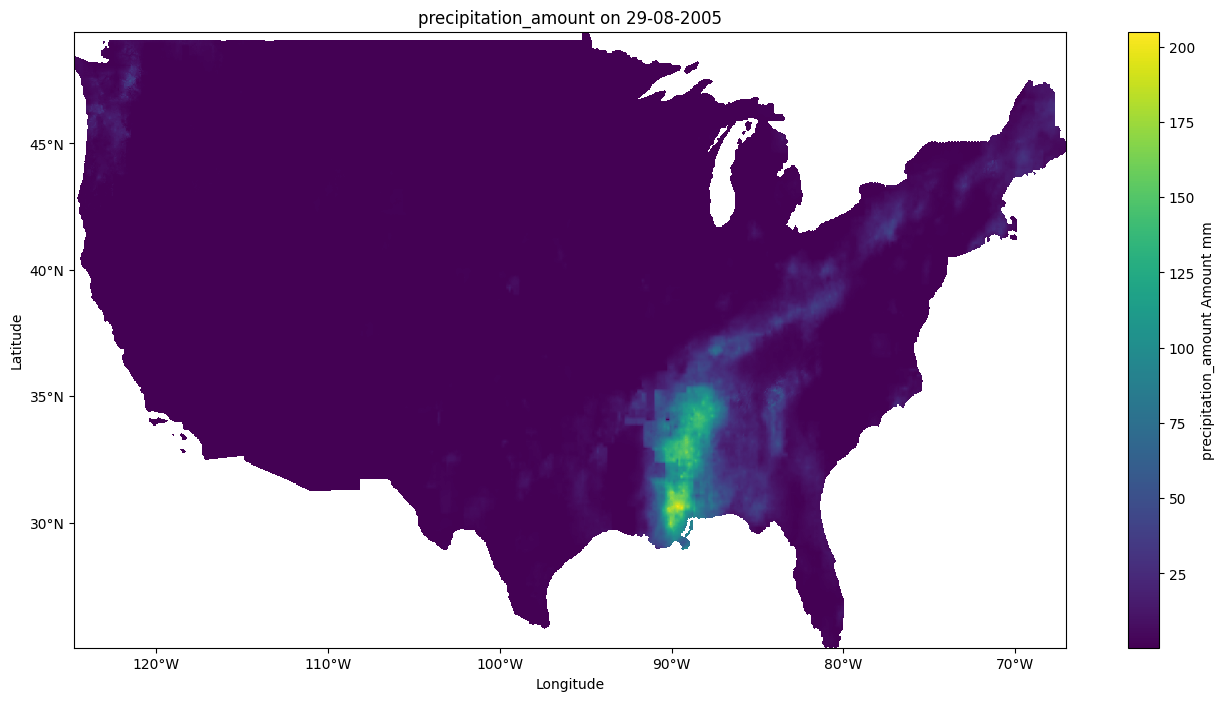

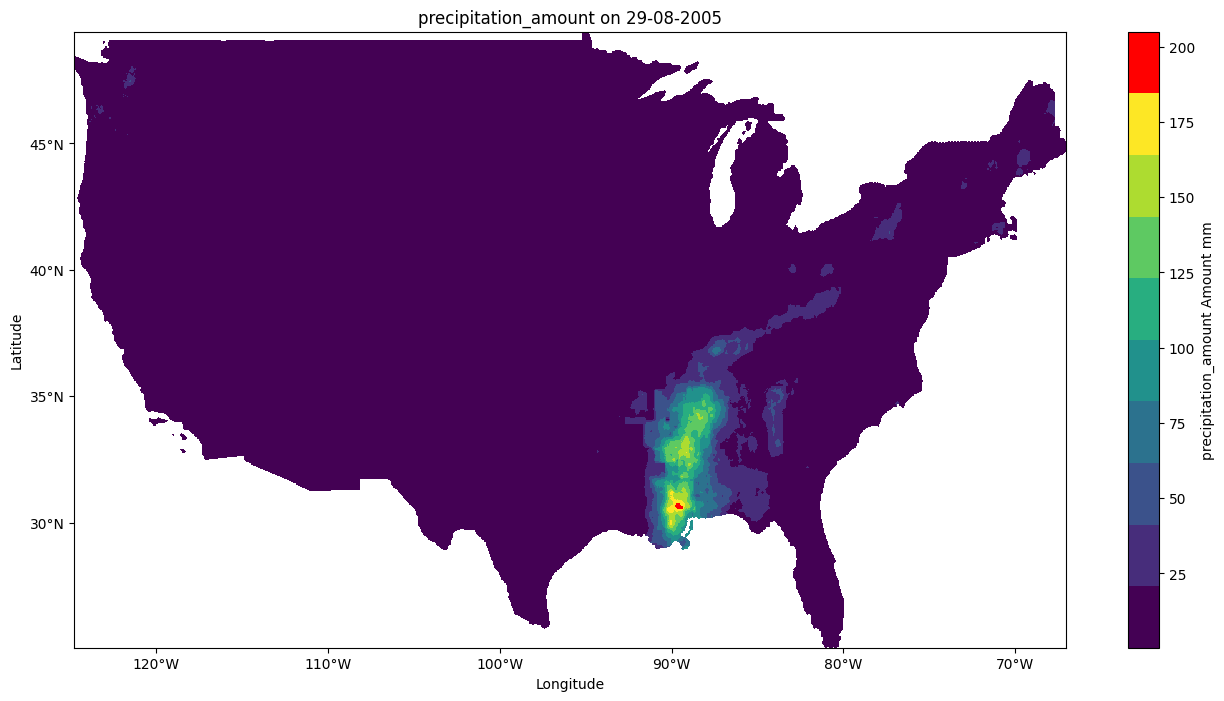

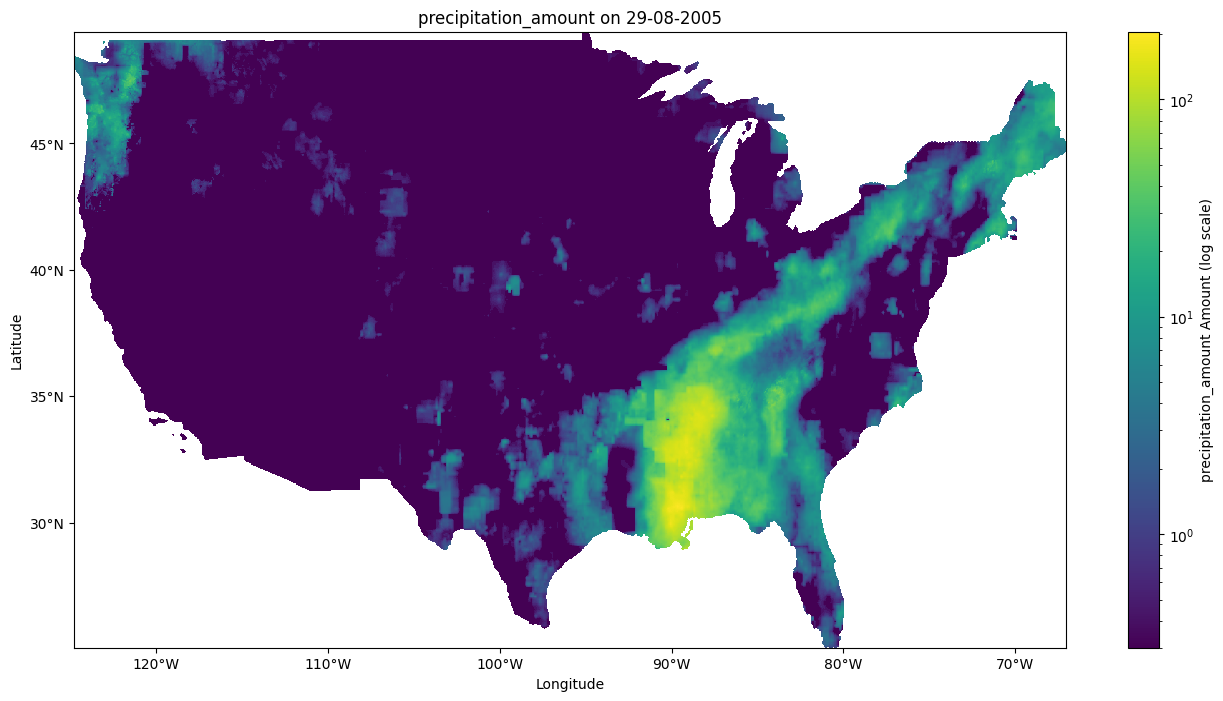

<Figure size 640x480 with 0 Axes>

In [148]:
plot_variable_continuous('pr_2005.nc', 'precipitation_amount', day_index=240, units="mm")
plot_variable_discrete('pr_2005.nc', 'precipitation_amount', day_index=240, units="mm")
plot_variable_log('pr_2005.nc', 'precipitation_amount', day_index=240)

## Trying out different Colormaps for continuous colormapping for wind_speed variable 

In [149]:
def plot_div_seq(filename, var_name, day_index,colormaps,units):

    lons, lats, day_data, vmin, vmax = get_data(filename, var_name, day_index)
    
    lon, lat = np.meshgrid(lons, lats)
    
    
    for cmap_name in colormaps:
       
        fig, ax = plt.subplots(figsize=(16, 8))
        cmap = plt.get_cmap(cmap_name)  

       
        pcm = ax.pcolormesh(lon, lat, day_data, shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)

        cbar = fig.colorbar(pcm, ax=ax, orientation='vertical')
        cbar.set_label(f'{var_name} Amount {units}')

        date=get_date(day_index)
        ax.set_xticks([-120, -110, -100, -90, -80, -70])
        ax.set_xticklabels([f'{abs(x)}°W' for x in [-120, -110, -100, -90, -80, -70]])
        ax.set_yticks([30, 35, 40, 45])
        ax.set_yticklabels([f'{y}°N' for y in [30, 35, 40, 45]])

        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'{var_name} on {date} - Colormap: {cmap_name}')
        

        plt.show()


### DIVERGET COLORMAP

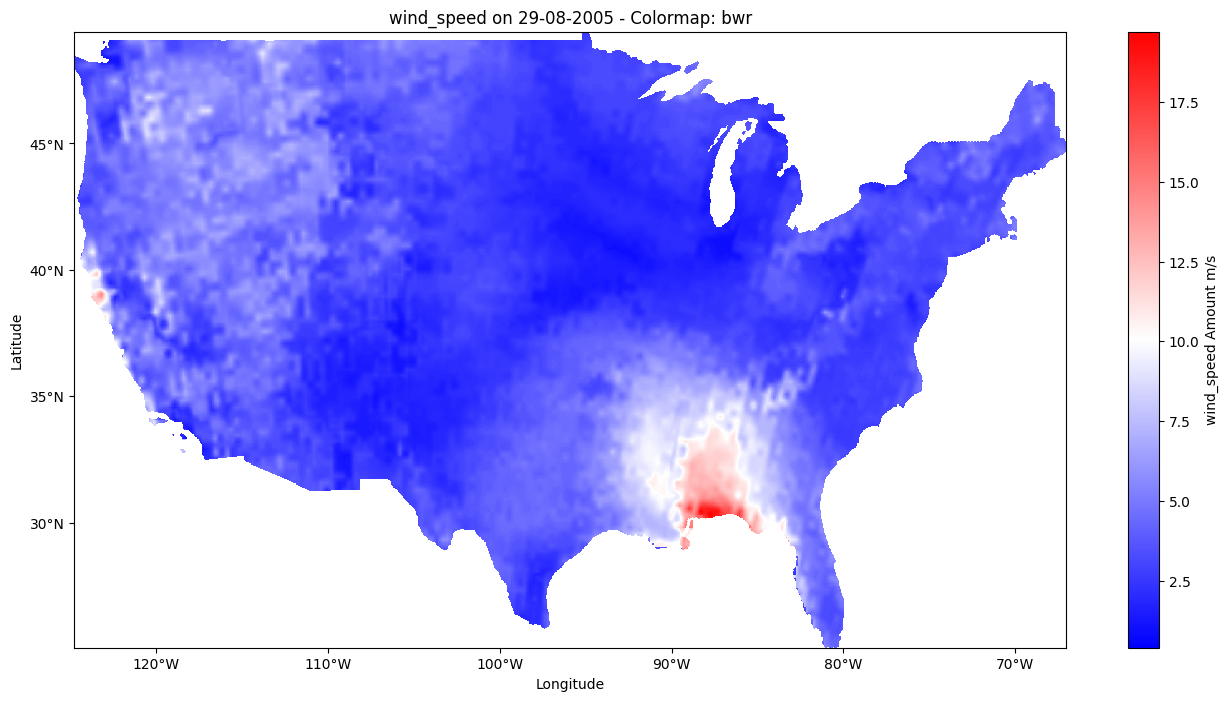

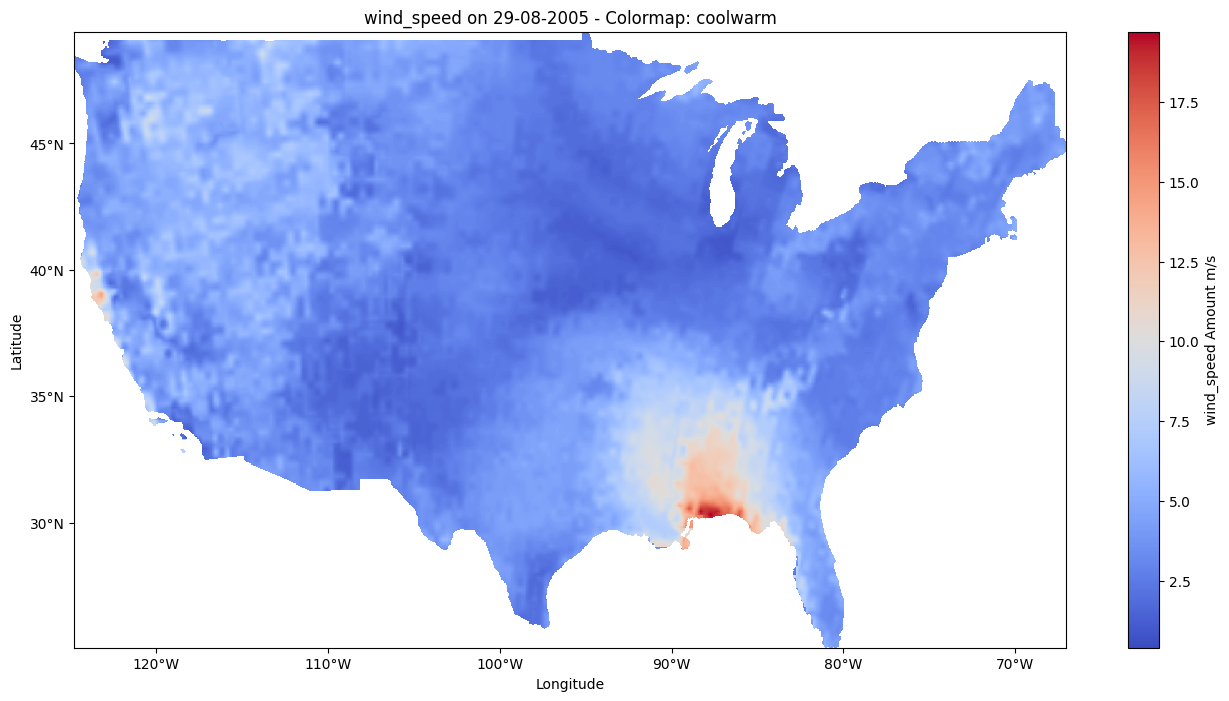

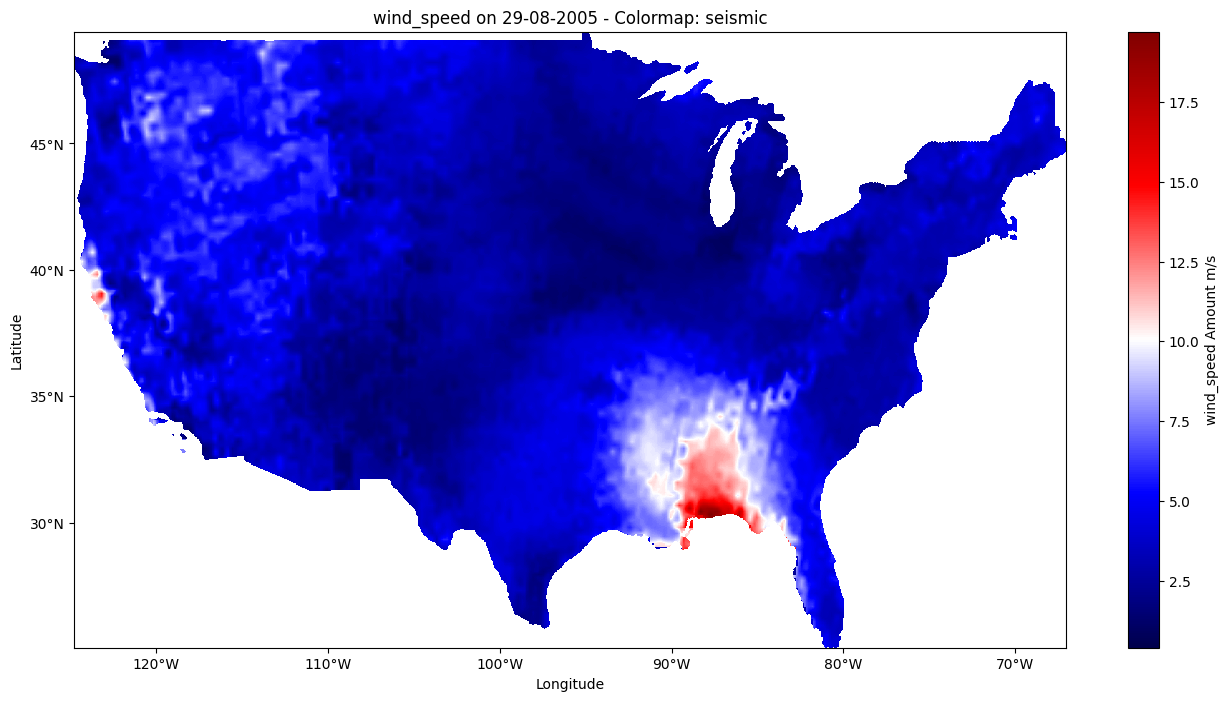

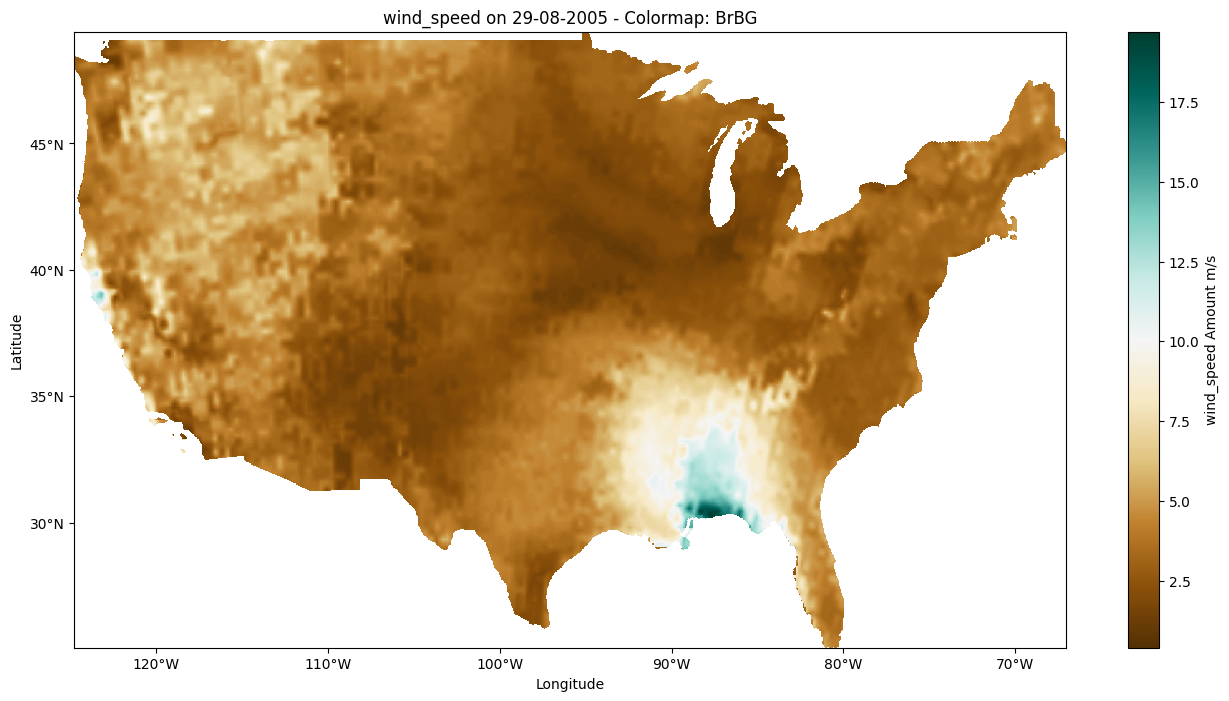

In [150]:
#Trying out different divergent colormap
plot_div_seq('vs_2005.nc', 'wind_speed', day_index=240, colormaps=['bwr', 'coolwarm', 'seismic', 'BrBG'],units="m/s")


### SEQUENTIAL COLORMAP

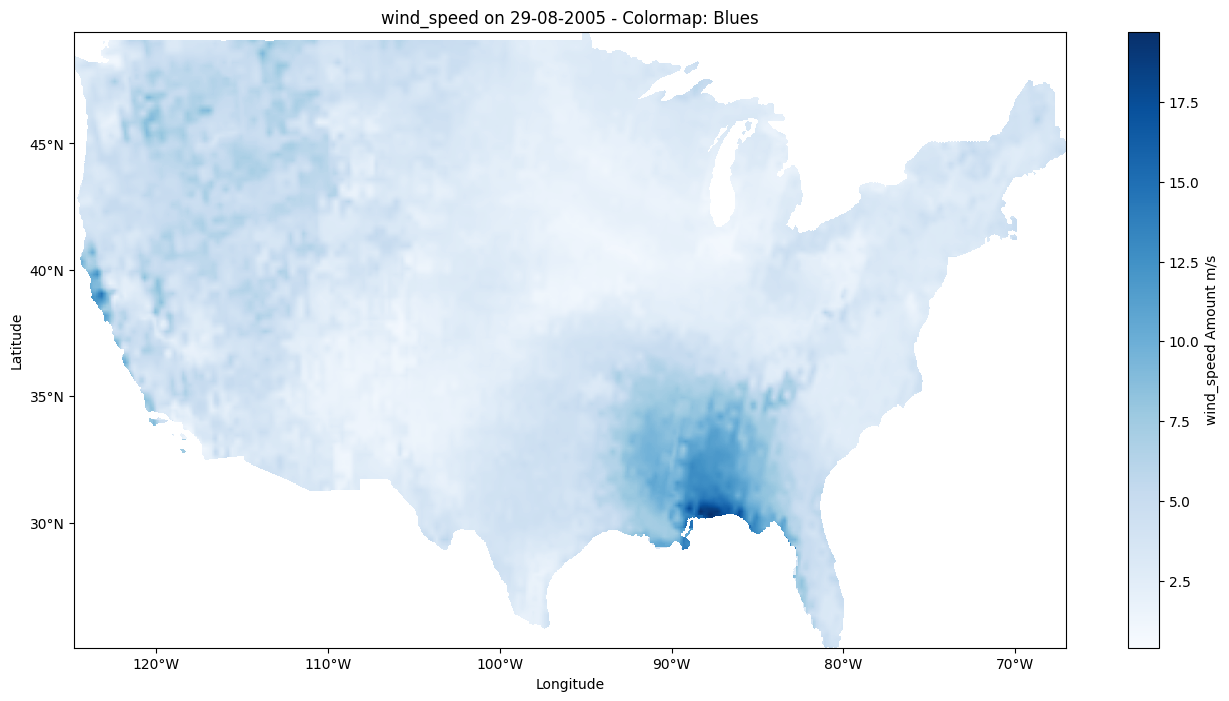

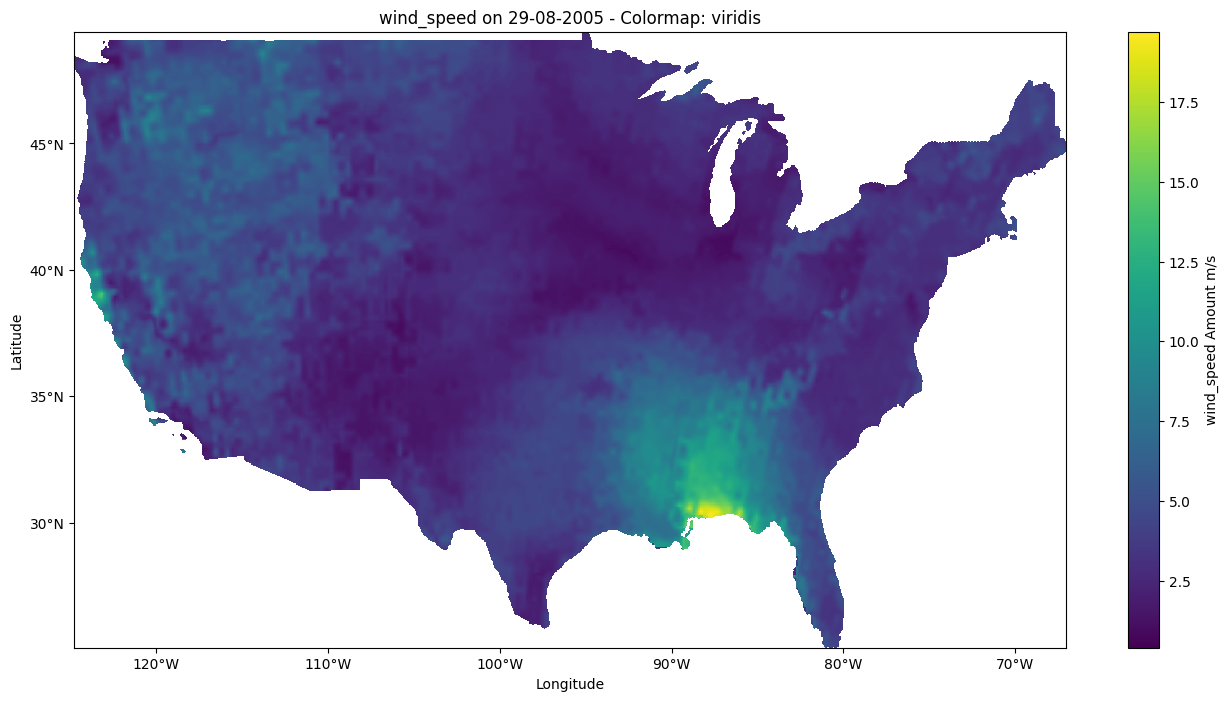

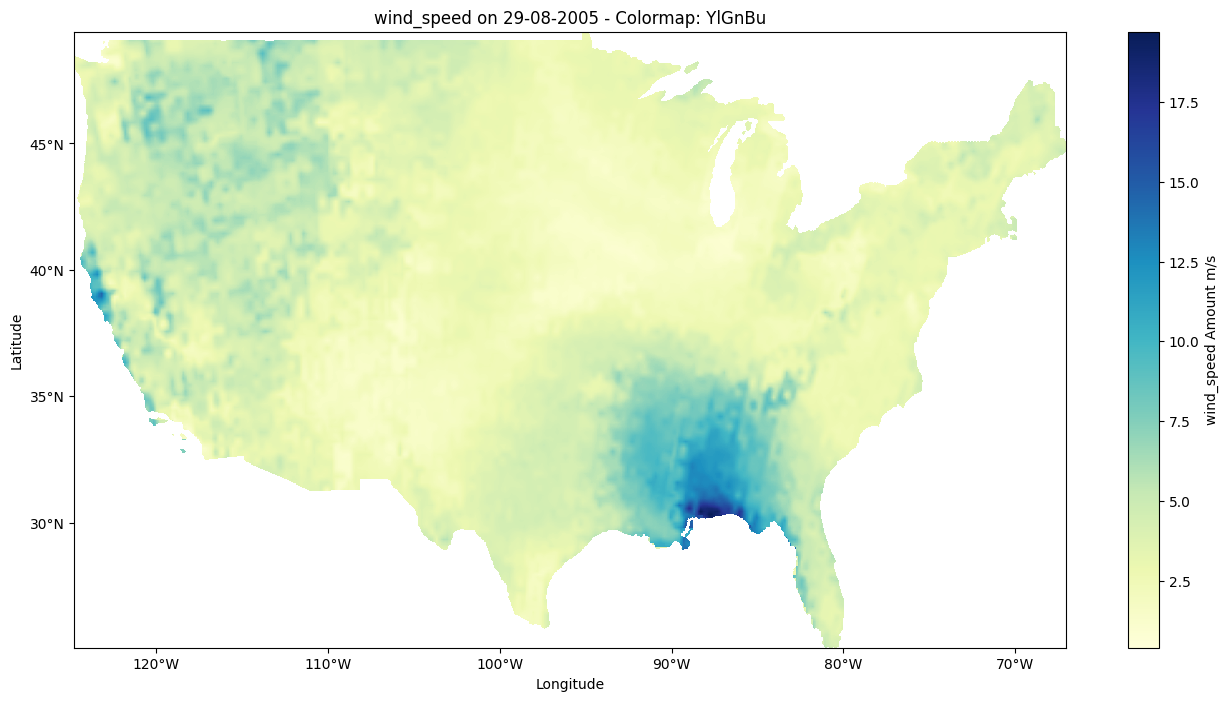

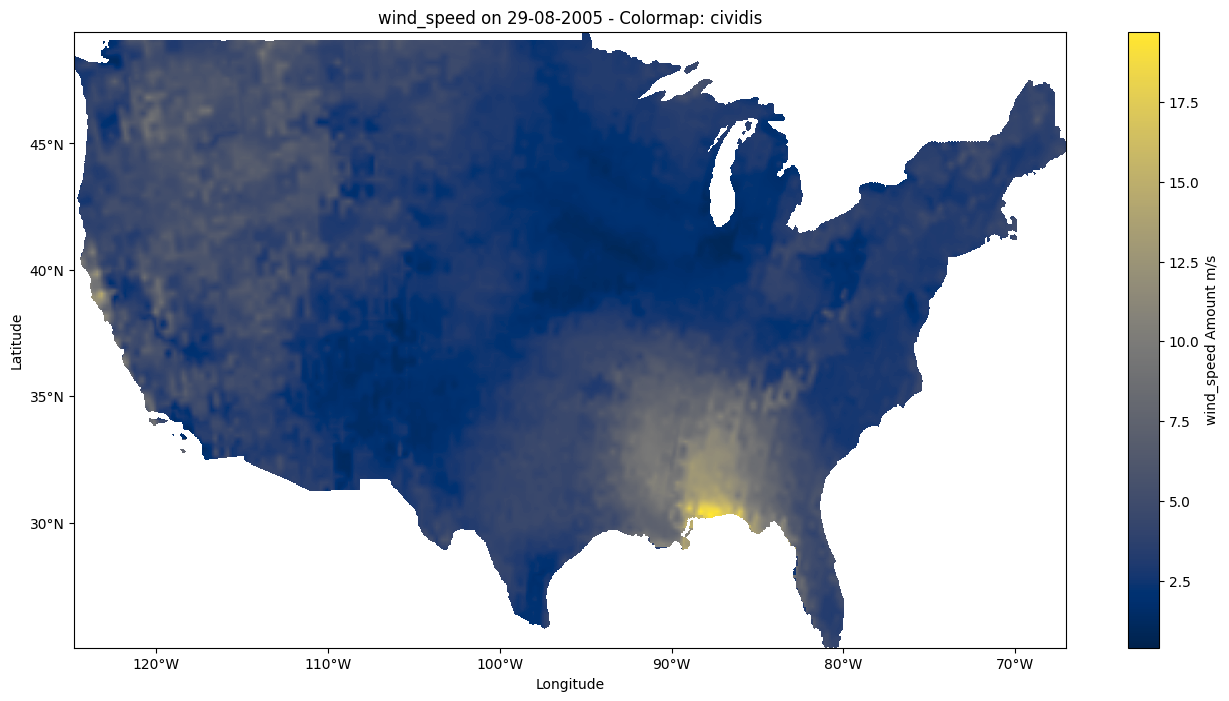

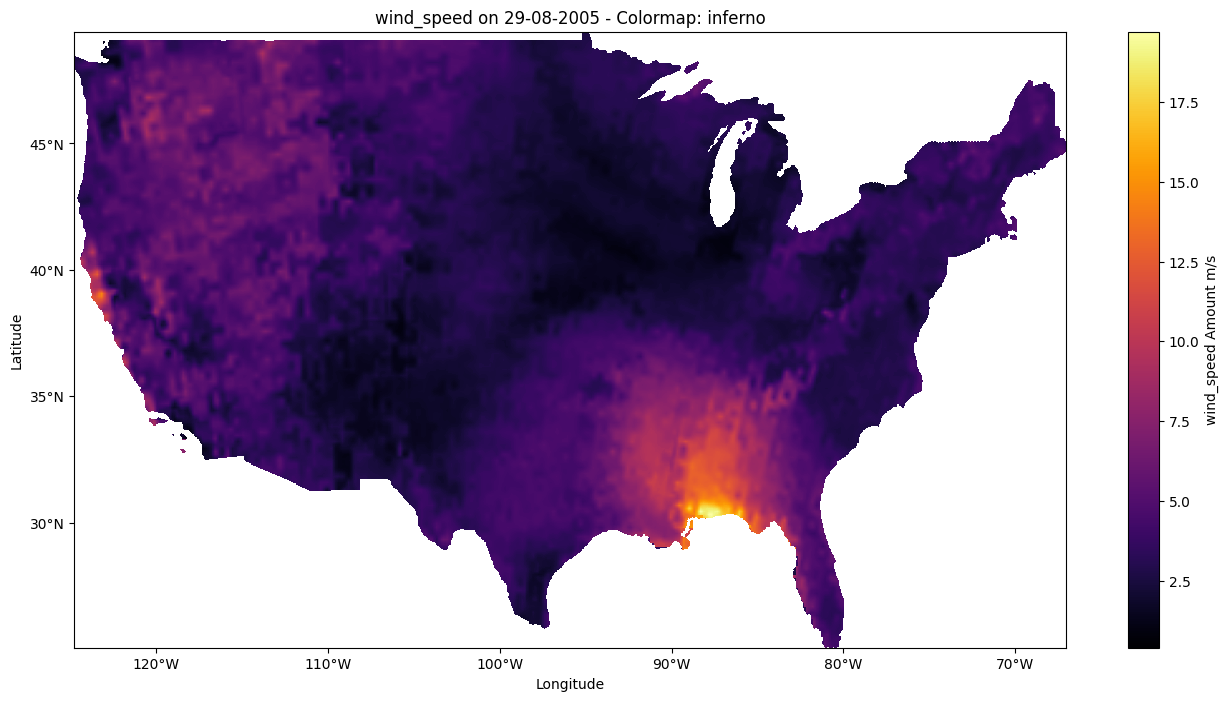

In [151]:
#Trying out different sequential colormaps
plot_div_seq('vs_2005.nc', 'wind_speed', day_index=240, colormaps= ['Blues', 'viridis', 'YlGnBu', 'cividis','inferno'],units="m/s")

### Continuous Colormap for the sampled dates using sequential colormap for Precipitation_Amount Variable

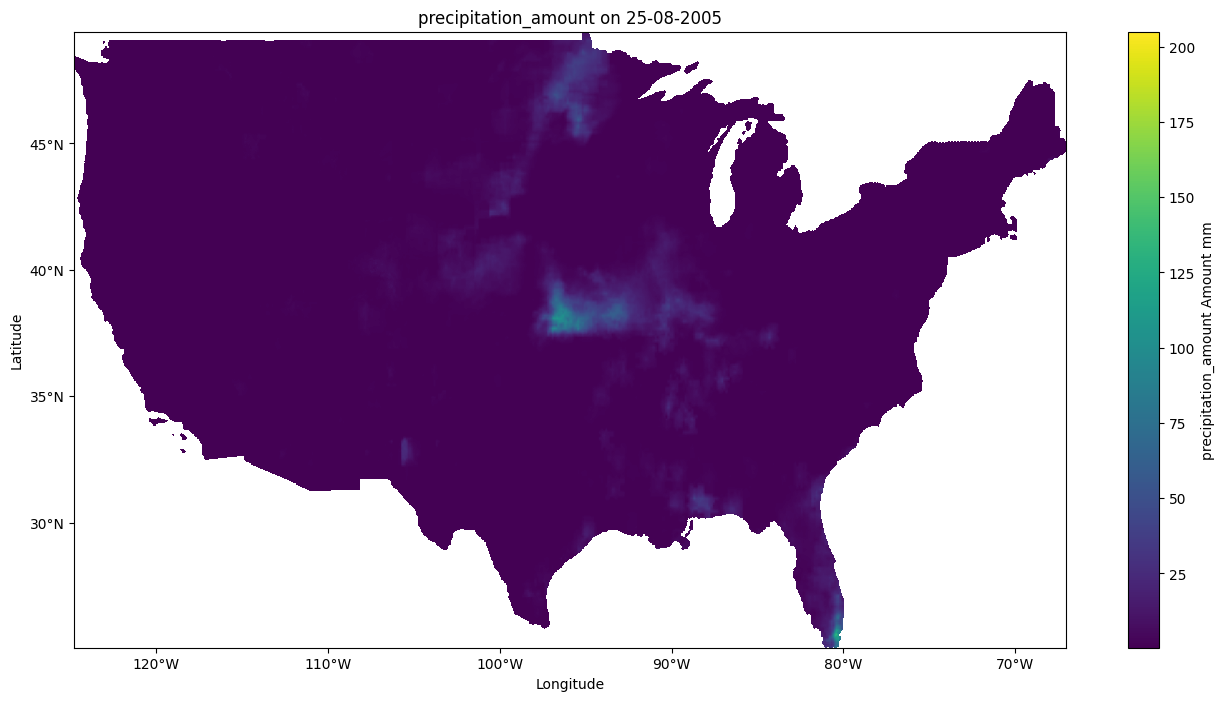

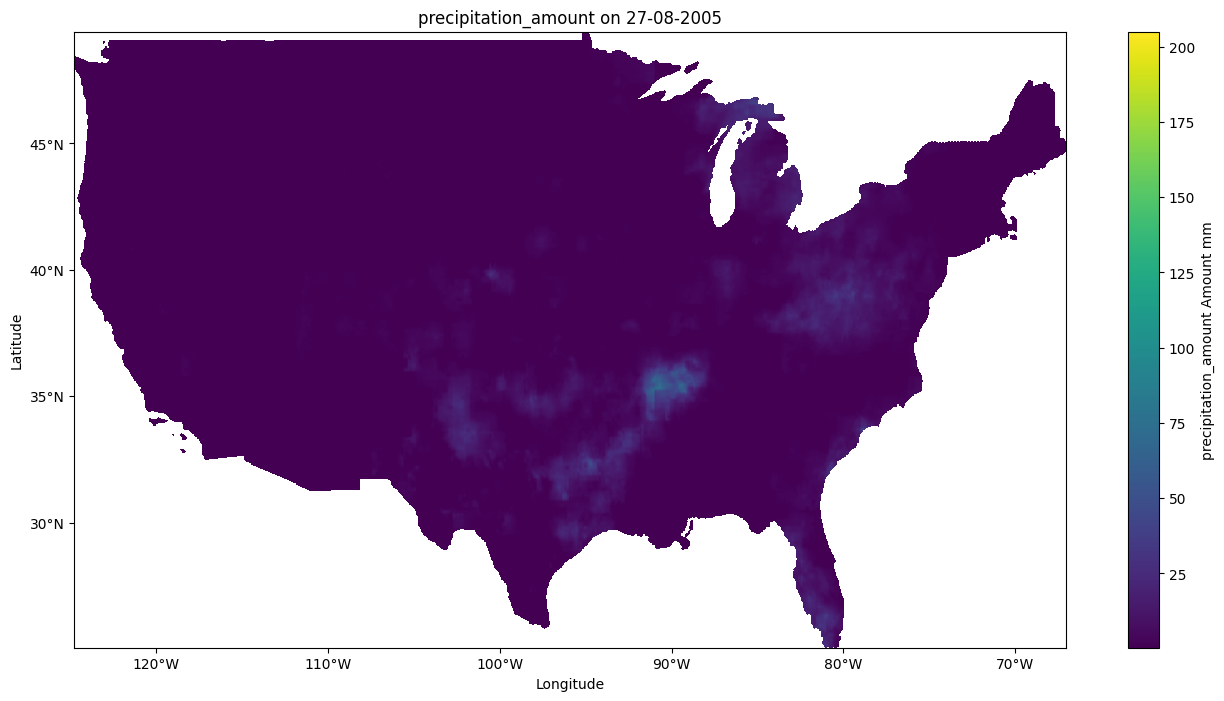

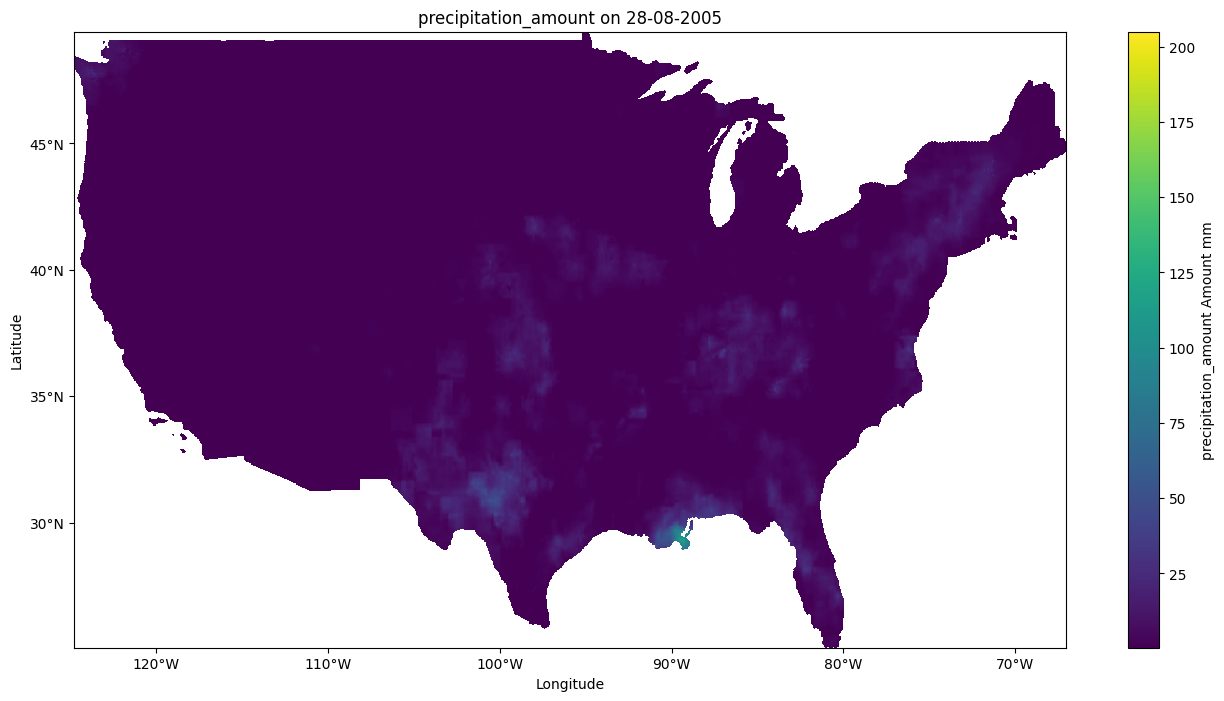

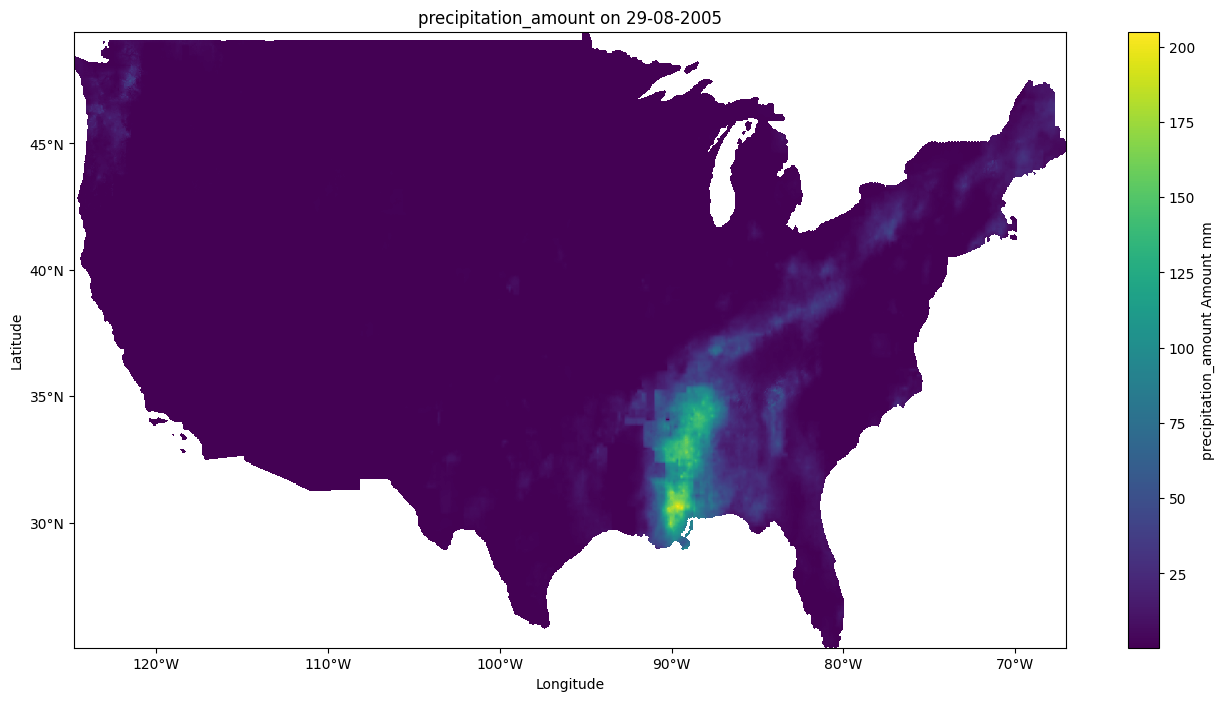

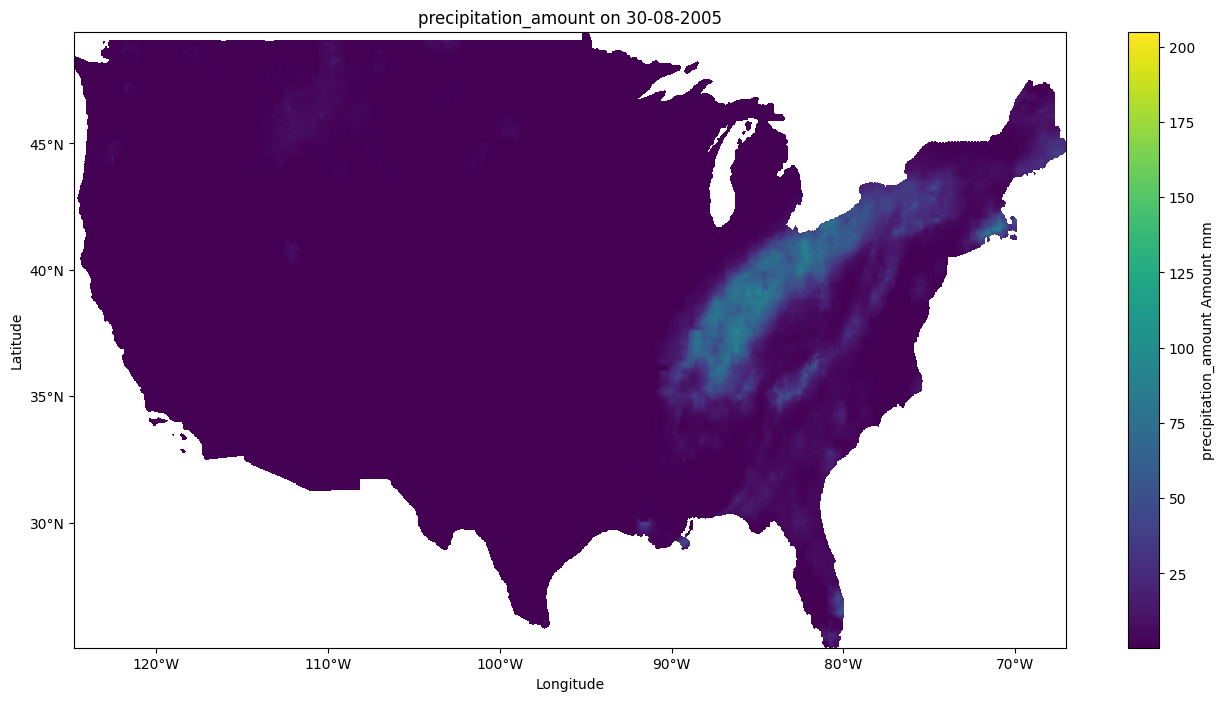

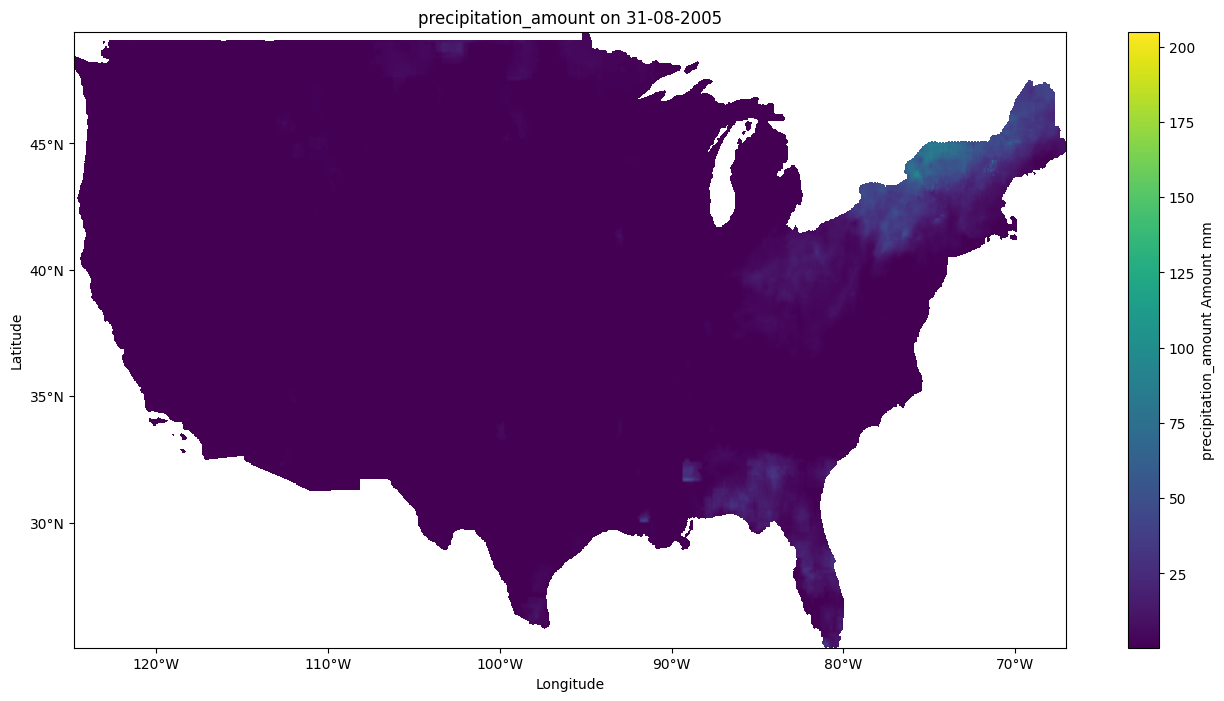

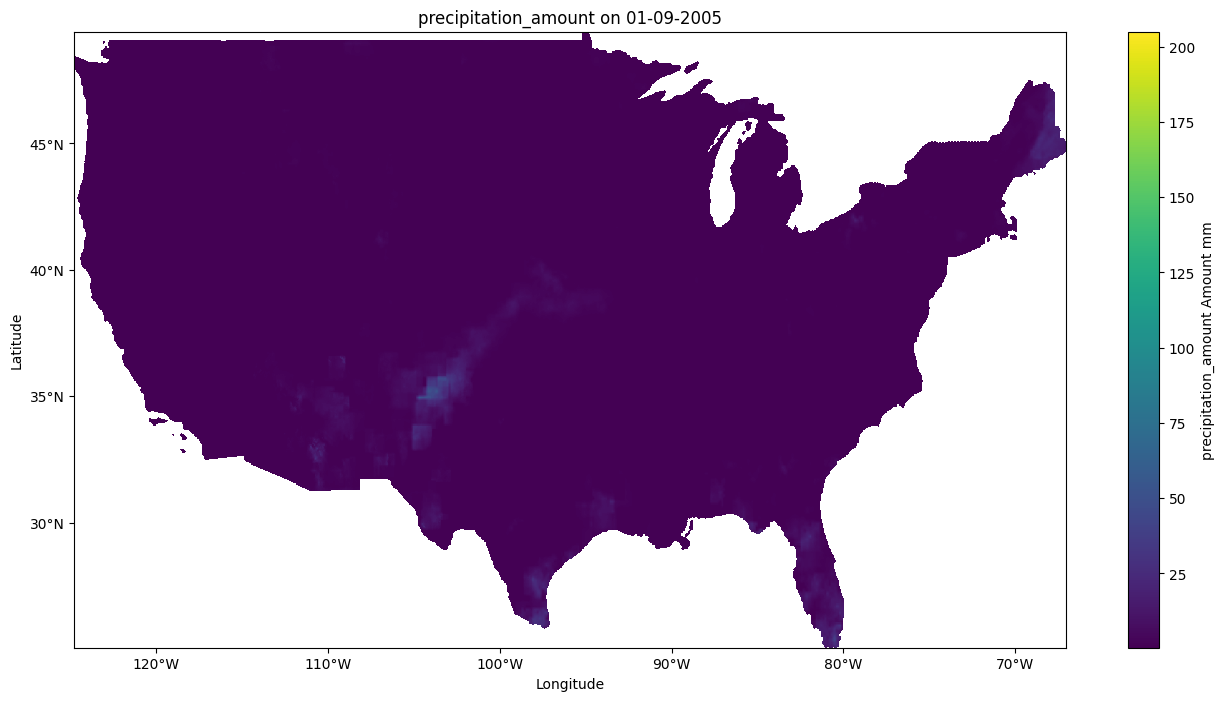

In [152]:
# For all the sampled days ,precipitation_amount variable 
day_indices =[236, 238, 239, 240, 241, 242,243]
for day_index in day_indices:
    plot_variable_continuous('pr_2005.nc', 'precipitation_amount', day_index,units="mm")

### Continuous Colormap for the sampled dates using sequential colormap for Wind_Speed Variable

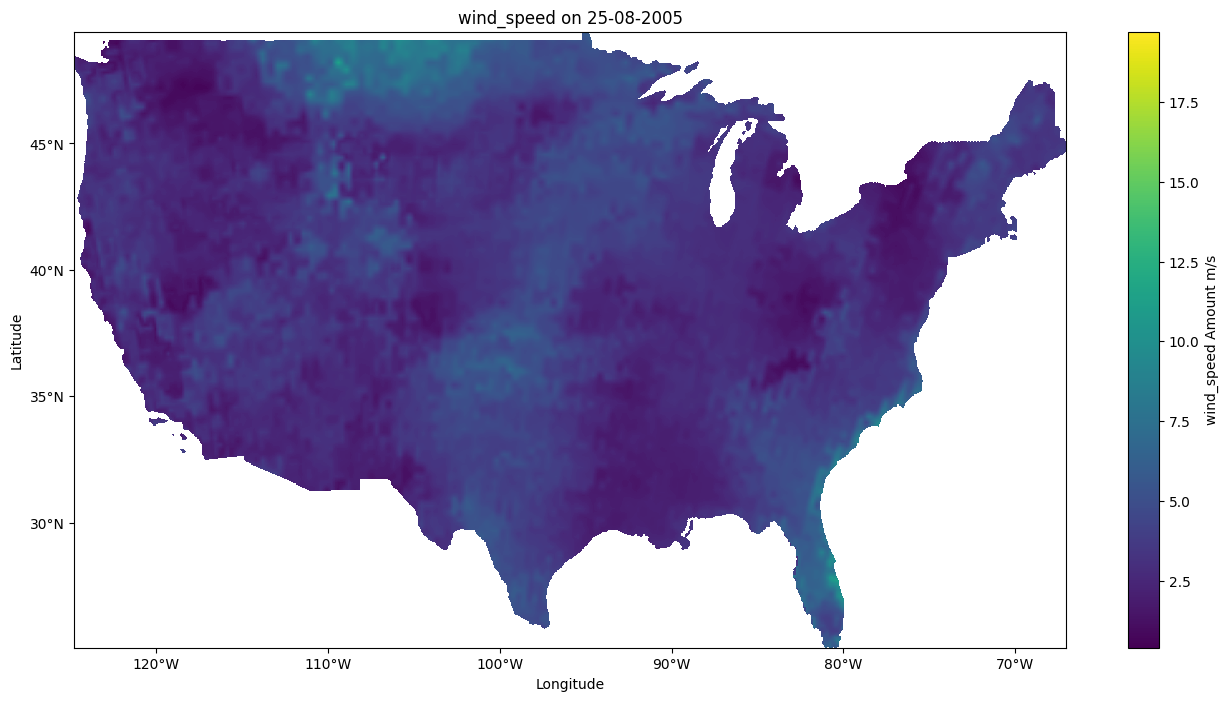

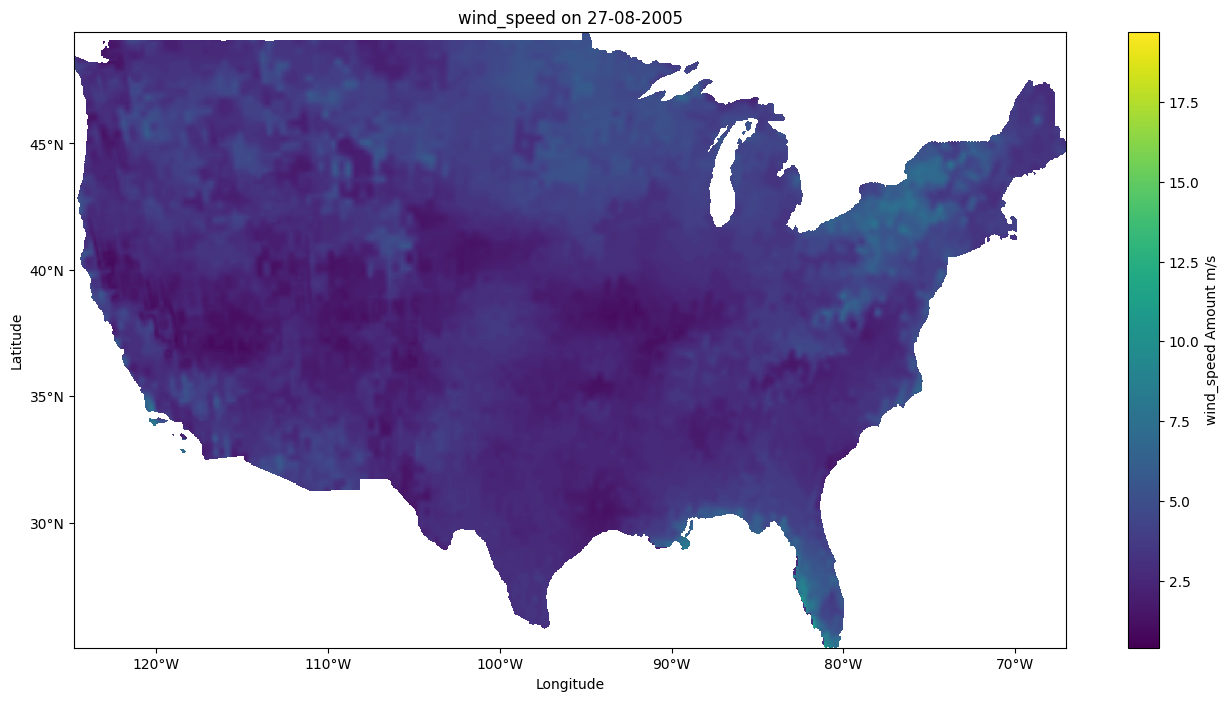

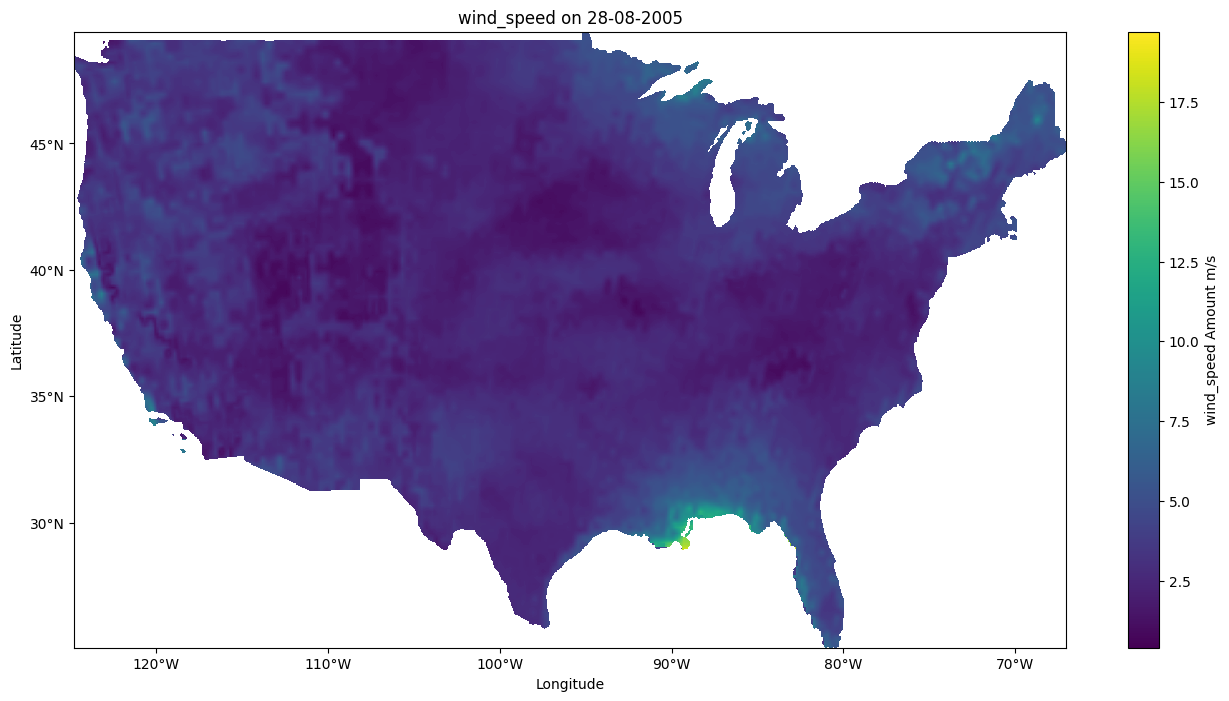

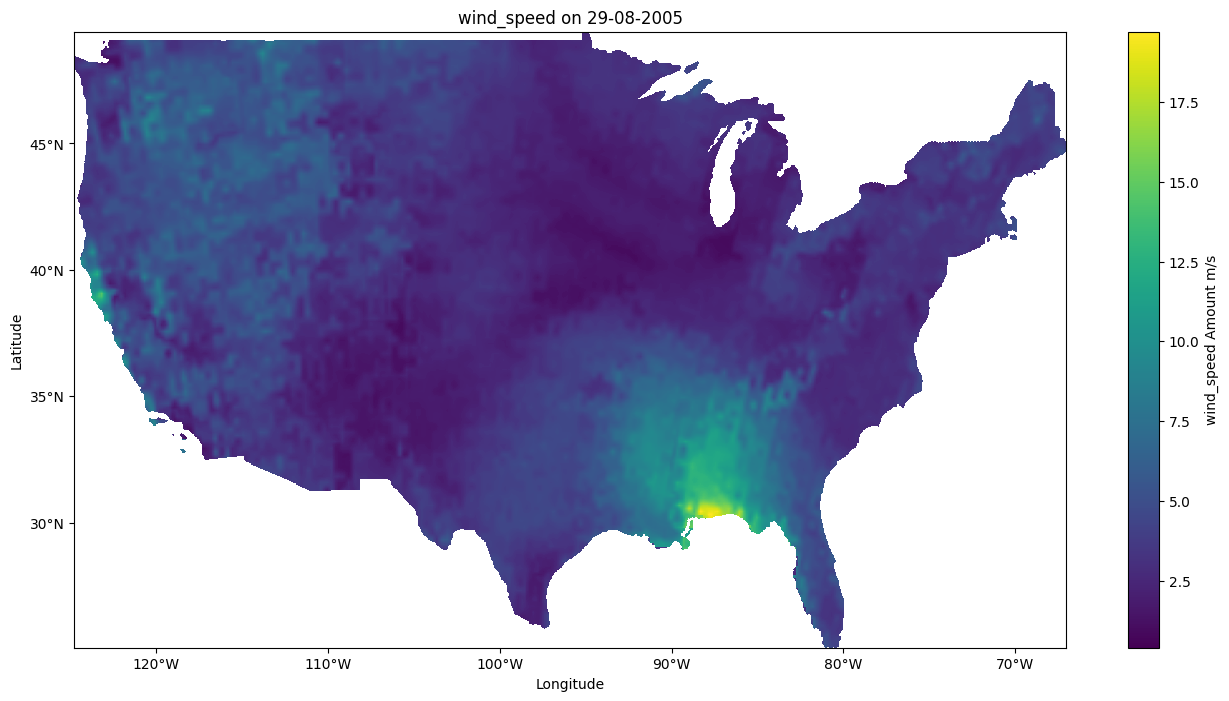

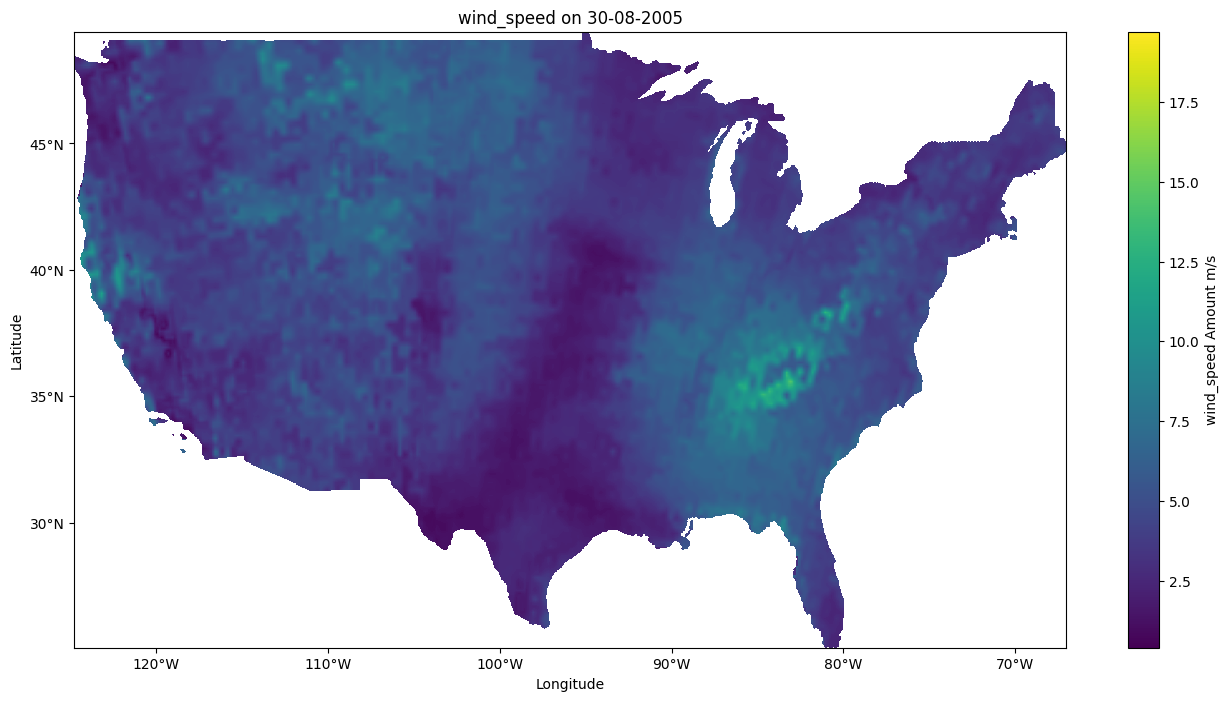

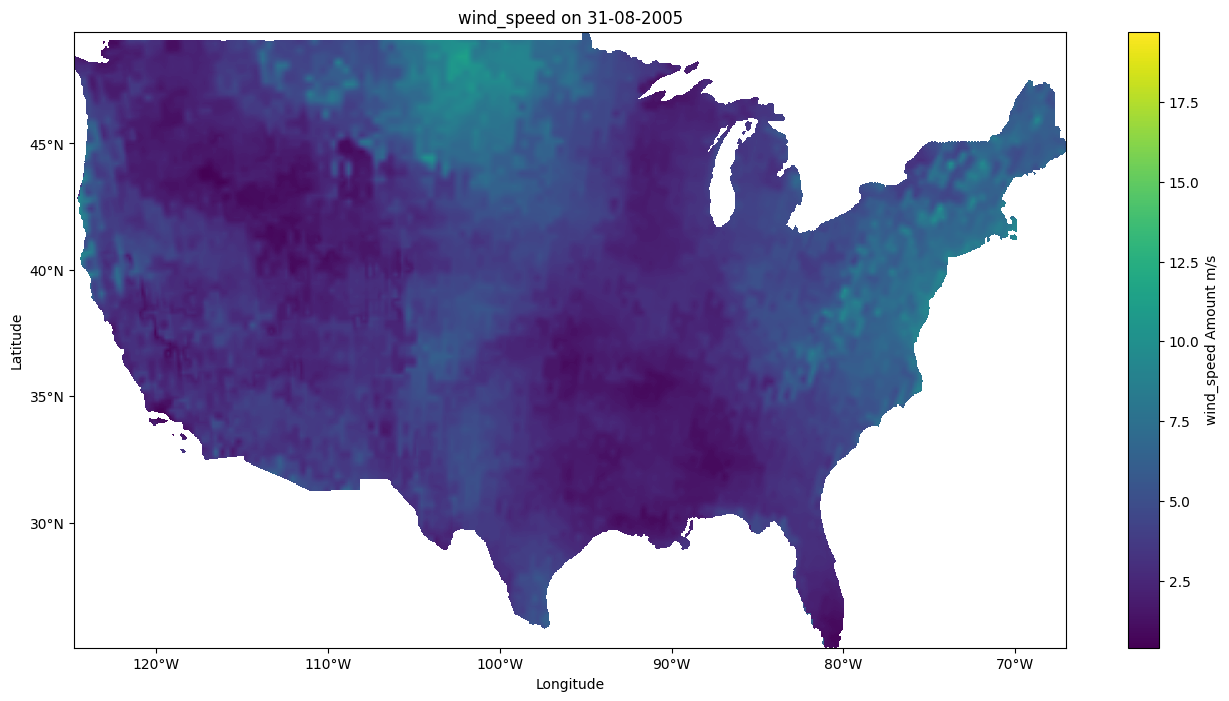

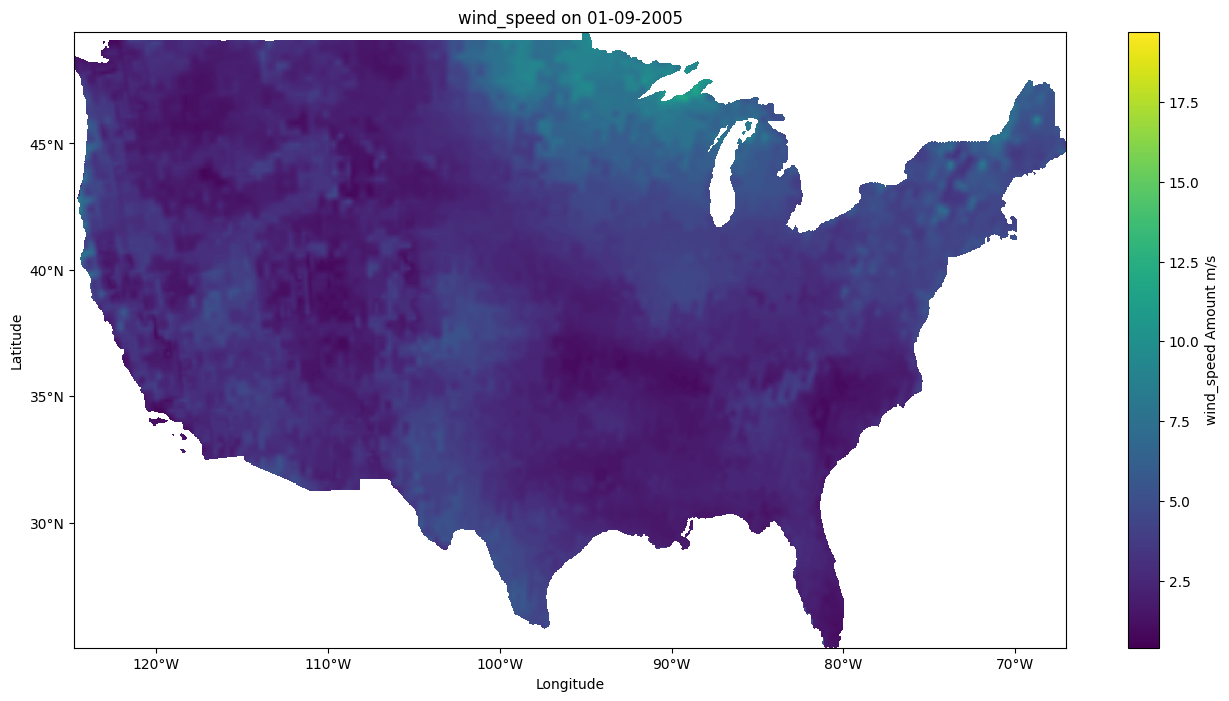

In [153]:
# For all sampled days ,wind_speed variable
day_indices = [236, 238, 239, 240, 241, 242,243]
for day_index in day_indices:
    plot_variable_continuous('vs_2005.nc', 'wind_speed', day_index,units="m/s")

 # ANIMATION GIF

In [154]:
def create_animation(file_name, variable_name, output_file,units):
    data = Dataset(file_name)
    lats = data.variables['lat'][:]
    lons = data.variables['lon'][:]
    variable_data = data.variables[variable_name][:]
    lon, lat = np.meshgrid(lons, lats)
    
    vmin, vmax = calculate_global_min_max(file_name, variable_name)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    cmap = plt.get_cmap('viridis')
    
    pcm = ax.pcolormesh(lons, lats, np.zeros_like(variable_data[0, :, :]),
                        shading='auto', cmap=cmap, vmin=vmin, vmax=vmax)
    
    cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(f'{variable_name} {units}')
    
    ax.set_xticks([-120, -110, -100, -90, -80, -70])
    ax.set_xticklabels([f'{abs(x)}°W' for x in [-120, -110, -100, -90, -80, -70]])
    ax.set_yticks([30, 35, 40, 45])
    ax.set_yticklabels([f'{y}°N' for y in [30, 35, 40, 45]])

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    day_indices = [236, 238, 239, 240, 241, 242,243]
    def update(day_index):
        date=get_date(day_index) 
        ax.set_title(f'{variable_name} on {date}')
        day_data = variable_data[day_index, :, :]
        pcm.set_array(day_data.ravel())
    
    ani = FuncAnimation(fig, update, frames=day_indices, interval=1000, repeat=True)
    ani.save(output_file, writer='pillow', fps=1)
    
    plt.show()



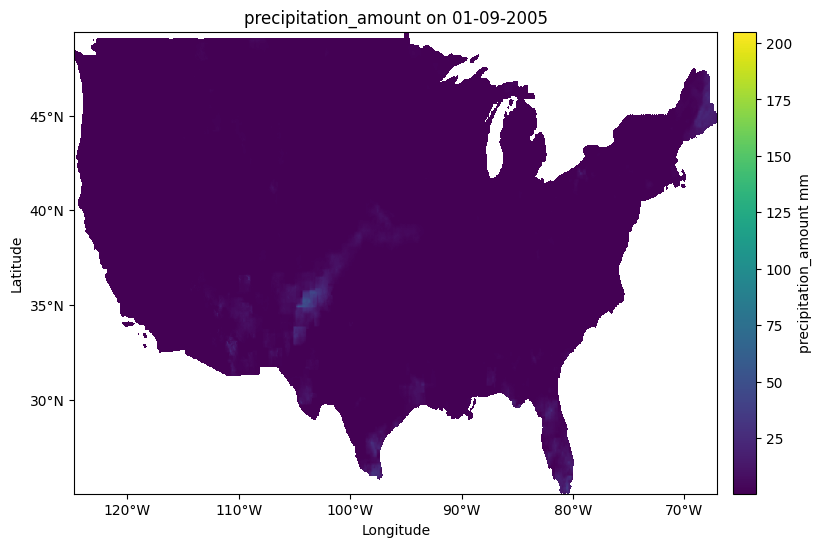

In [155]:
create_animation('pr_2005.nc', 'precipitation_amount','precipitation_animation.gif',units="mm")


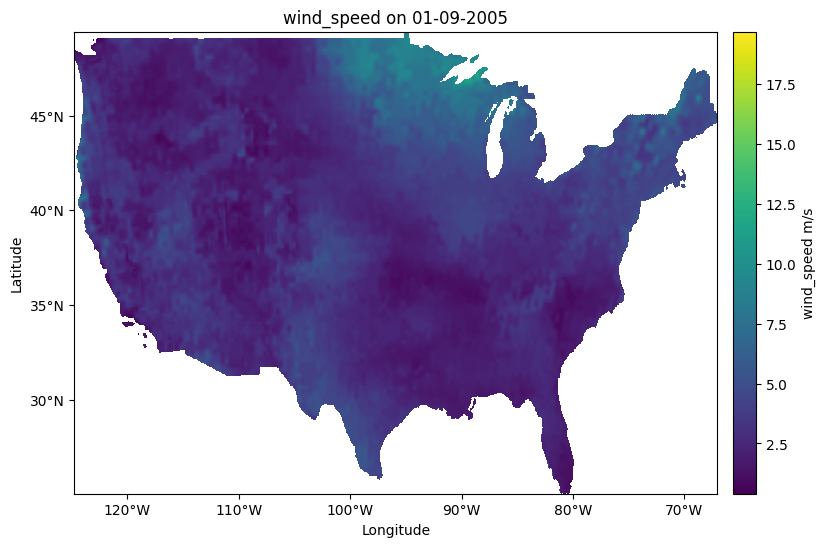

In [156]:
create_animation('vs_2005.nc', 'wind_speed','wind_animation.gif',units="m/s")
